In [1]:
#pip install pyspark

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import re

In [3]:
#Create spark session
spark = SparkSession \
    .builder \
    .appName("Inverted Index") \
    .getOrCreate()

In [4]:
spark.version

'3.1.2'

In [5]:
#sc

In [6]:
!ls /data/

QueryR.csv  QueryR_wordcount.csv  QueryR_wordcount.txt


In [7]:
#Create directory to put csv file
!hdfs dfs -mkdir /data

mkdir: `/data': File exists


In [8]:
#Move csv file into hdfs
!hdfs dfs -copyFromLocal -p data/QueryR.csv /data

copyFromLocal: `/data/QueryR.csv': File exists


In [9]:
#Verify that file is in hdfs
!hdfs dfs -ls /data

Found 4 items
-rw-r--r--   2 root root      2293727 2022-03-03 23:23 /data/QueryR.csv
drwxr-xr-x   - root hadoop          0 2022-03-04 03:18 /data/QueryR_wordcount.csv
drwxr-xr-x   - root hadoop          0 2022-03-04 02:01 /data/QueryR_wordcount.txt
-rw-r--r--   2 root hadoop    8077509 2022-03-03 20:35 /data/QueryResults.csv


In [10]:
#Convert and import csv file to RDD
qr = sc.textFile('/data/QueryR.csv')

In [11]:
from pyspark.rdd import RDD
isinstance(qr, RDD)

True

In [12]:
#Clean and split tags (Map). Re.sub was used to remove all special characters and spaces
qr_list = qr.map(lambda x: re.sub("[^a-zA-Z]", " ", x).split())
#[^a-zA-Z] #can be used to remove numbers in Id 
#[>,\"] .split('<') #doesnt remove whitespace 

In [13]:
qr_list.take(5)

[['Id', 'tags'],
 ['algorithm', 'time', 'time', 'complexity'],
 ['sql', 'postgresql', 'database', 'design'],
 ['c', 'dynamic', 'memory', 'allocation', 'realloc'],
 ['dart', 'async', 'await', 'getter']]

In [14]:
#FlatMap is used to remove the list aspect (flatten nested list) of our filtered list and assign every word a value of 1
qr_tuple = qr_list.flatMap(lambda qr_list: [(word, 1) for word in qr_list])

In [15]:
qr_tuple.take(5)

[('Id', 1), ('tags', 1), ('algorithm', 1), ('time', 1), ('time', 1)]

In [16]:
#Get the sum of how many times a word is presented (Reduce)
qr_counts = qr_tuple.reduceByKey(lambda total, count: total + count)

In [25]:
type(qr_counts)

pyspark.rdd.PipelinedRDD

In [52]:
qrColumns = ['tags', 'count']

In [54]:
qrDFSQL = spark.createDataFrame(qr_counts, schema = qrColumns)
qrDFSQL.printSchema()
qrDFSQL.show(truncate=False)

root
 |-- tags: string (nullable = true)
 |-- count: long (nullable = true)

+----------+-----+
|tags      |count|
+----------+-----+
|tags      |19   |
|algorithm |210  |
|database  |616  |
|design    |158  |
|c         |5354 |
|dart      |410  |
|await     |105  |
|java      |3614 |
|cloud     |1067 |
|binder    |3    |
|boot      |663  |
|junit     |103  |
|calls     |7    |
|preload   |1    |
|reactjs   |2027 |
|material  |240  |
|php       |2052 |
|euclidean |3    |
|distance  |13   |
|accelerate|1    |
+----------+-----+
only showing top 20 rows



In [60]:
type(qrDFSQL)

pyspark.sql.dataframe.DataFrame

In [55]:
# Other method for creating pyspark.sql.df
#from pyspark.sql.types import StructType,StructField, StringType
#deptSchema = StructType([       
#    StructField('tags', StringType(), True),
#   StructField('count', StringType(), True)
#])
#
#deptDF1 = spark.createDataFrame(qr_counts, schema = deptSchema)
#deptDF1.printSchema()
#deptDF1.show(truncate=False)

root
 |-- tags: string (nullable = true)
 |-- count: string (nullable = true)

+----------+-----+
|tags      |count|
+----------+-----+
|tags      |19   |
|algorithm |210  |
|database  |616  |
|design    |158  |
|c         |5354 |
|dart      |410  |
|await     |105  |
|java      |3614 |
|cloud     |1067 |
|binder    |3    |
|boot      |663  |
|junit     |103  |
|calls     |7    |
|preload   |1    |
|reactjs   |2027 |
|material  |240  |
|php       |2052 |
|euclidean |3    |
|distance  |13   |
|accelerate|1    |
+----------+-----+
only showing top 20 rows



In [56]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

data = qr_counts

columns = ["tags","count"]
pysparkDF = spark.createDataFrame(data = data, schema = columns)
pysparkDF.printSchema()
pysparkDF.show(truncate=False)

root
 |-- tags: string (nullable = true)
 |-- count: long (nullable = true)

+----------+-----+
|tags      |count|
+----------+-----+
|tags      |19   |
|algorithm |210  |
|database  |616  |
|design    |158  |
|c         |5354 |
|dart      |410  |
|await     |105  |
|java      |3614 |
|cloud     |1067 |
|binder    |3    |
|boot      |663  |
|junit     |103  |
|calls     |7    |
|preload   |1    |
|reactjs   |2027 |
|material  |240  |
|php       |2052 |
|euclidean |3    |
|distance  |13   |
|accelerate|1    |
+----------+-----+
only showing top 20 rows



In [57]:
type(pysparkDF)

pyspark.sql.dataframe.DataFrame

In [58]:
qrDF = pysparkDF.toPandas()
print(pandasDF)

                 tags  count
0                tags     19
1           algorithm    210
2            database    616
3              design    158
4                   c   5354
...               ...    ...
9393  virtuallistview      1
9394            magit      1
9395         hardcode      1
9396         datasnap      1
9397   httpcomponents      1

[9398 rows x 2 columns]


In [59]:
type(qrDF)

pandas.core.frame.DataFrame

In [62]:
qrDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9398 entries, 0 to 9397
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tags    9398 non-null   object
 1   count   9398 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 147.0+ KB


In [78]:
qrDF.loc[0:10]

,tags,count
0,tags,19
1,algorithm,210
2,database,616
3,design,158
4,c,5354
5,dart,410
6,await,105
7,java,3614
8,cloud,1067
9,binder,3


In [82]:
column = qrDF
max_value = column.max()

In [94]:
max_value

tags     zynq
count    8920
dtype: object

In [96]:
#Find max 
qrDF.sort_values('count',ascending=False)

,tags,count
23,python,8920
4787,javascript,5457
4,c,5354
25,android,3647
7,java,3614
...,...,...
4415,glade,1
4416,drawingarea,1
4417,cgpoint,1
4418,pikepdf,1


In [99]:
#Get 5 most popular tags
qrDF.nlargest(5,'count')

,tags,count
23,python,8920
4787,javascript,5457
4,c,5354
25,android,3647
7,java,3614


In [100]:
qrlargest = qrDF.nlargest(5,'count')
#print(qrlargest)

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

In [104]:
#qrlargest.groupby(['tags'])['count'].head()

<AxesSubplot:ylabel='tags'>

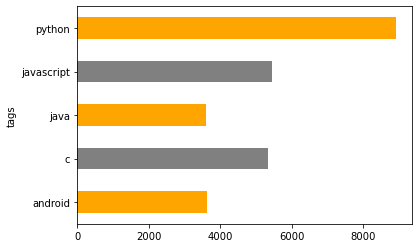

In [111]:
qrlargest.groupby(['tags'])['count'].sum().plot(kind = 'barh', color = ('orange','gray'))

In [18]:
#Convert file to textfile
##qr_counts.saveAsTextFile('/data/QueryR_wordcount.txt')

In [19]:
#!hdfs dfs -ls

In [20]:
#Move file to local from hdfs for export
##!hdfs dfs -copyToLocal -p /data /QueryR_wordcount.txt

In [21]:
#other method for converting csv file
#df = spark.read.load("/data/QueryR.csv",format="csv", sep=",", inferSchema="true", header="true")

In [22]:
#df.show(10)

In [23]:
#for x in df:
#    print(x)

In [24]:
#from pyspark.sql import functions as F
#df.sort(F.desc("tags")).show()